In [1]:
from sklearn.feature_extraction import text
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model, ensemble, naive_bayes

import pandas as pd
import numpy as np
import joblib
from itertools import chain


import utils, postprocessing, data, tuning

resource ~/nltk_data/corpora/stopwords not found. Downloading now...


KeyboardInterrupt: 

# Before running the following sections

In this notebook, there are three sections:
* Data reading and cleaning
* Building a model
* Assessing the peformance of the model

The model construction has two modes:
* A user-set model.
* A model selected after a grid search for hyperparameters.
Whether the first or second mode are selected is controlled by the boolean `run_cross_valid`. Also, if there is a saved grid search result,
then whether to choose to load or not is controlled by the boolean `load_grid_results`.

In [29]:
run_cross_valid = False
load_grid_results = True

# Data reading and cleaning
In this part, we perform data cleaning. This is done one time over the whole data sets, and comprises processing steps that are believed not affect the task at hand (sentiment analysis in this case. ) In other words, these steps are not tunable. Such steps necessarily do not depend on the training set, but solely on the example at hand. They include:
* Removing html tags
* Removing punctuation
* Shortening/Removing long spaces and other characters (i.e. underscores)

Once the cleaning is done (or if the cleaned file already exists), then a subset of training set is selected, on which most of the experiments to select a model are carried out.

In [30]:
df_train = data.load_clean_data(
    "./input/labeledTrainData.tsv", "./input/labeledTrainDataClean.tsv")

display(df_train.head(5))
df_train_sub = data.df_sample_stratified(
    df_train, stratify="sentiment", frac=0.2, random_state=0)

display(df_train_sub.head(5))


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious '...


,id,sentiment,review
9566,12427_7,1,This film has a lot of raw potential The scrip...
16286,12121_7,1,Somerset Maugham's characters are brought to l...
13443,9261_7,1,Which do you think the average person would kn...
1249,12081_8,1,Nina Foch delivers a surprisingly strong perfo...
2711,3844_8,1,"When you read the summary of this film, you mi..."


## Building and training a model
We build a model that is a succession of:
* One or many preprocessing steps, coded via the Scikit-Learn transformers. We use `TfidfVectorizer` which is equivalent to a `CountVectorizer` followed by `TfidfTransformer`.
* A classifier. By default, we choose a linear classifier optimized via the stochastic gradient descent algorithm.
  


In [14]:
model = Pipeline([
    # ("preproc", preprocessor),
    ("tfidf", text.TfidfVectorizer(use_idf=True, ngram_range=(1, 1),
                                   min_df=0.0, max_df=1.0,
                                   stop_words=utils.sw_nltk)),
    ("clf", linear_model.SGDClassifier(alpha=1e-4, penalty='l1')),
],
    memory=joblib.Memory(location="cachedir", verbose=0))

Then, for hyperparameter tuning, we use a grid search with Scikit-Learn's `GridSearchCV` functionality.

In [31]:
if run_cross_valid:

    model = utils.replace_head(model, ("clf", "passthrough"))

    grid_searcher = GridSearchCV(
        estimator=model,
        param_grid=[
            {
                'tfidf__ngram_range': [(1, 1), (1, 2)],

                "clf": list(chain.from_iterable(tuning.model_on_param_grid(*(model, grid)) for model, grid in 
                tuning.models_param_grid_zip)),
               
            },

        ],
        cv= 5, n_jobs= -1, verbose= 1,
        scoring='accuracy',
        return_train_score=True,
        refit=False,
    )
    grid_searcher.fit(df_train_sub["review"], df_train_sub["sentiment"])

    utils.save_obj(grid_searcher, "grid_search")
    cv_res = pd.DataFrame(grid_searcher.cv_results_)
    utils.save_obj(cv_res, "cv_results")
elif load_grid_results:
    # joblib.load("./cv_results/")
    cv_res = joblib.load("./cv_results/cv_results_2024-01-23_12:03:30.645133.joblib")

# Postprocessing and testing
To assess the performance of the model, we train it on the whole training set (not the subsample), and we visualize its performance both on the training and testing sets. 
We plot
* The average feature effects, where the computation of the effect depend on the used classifier.
* The confusion matrix
* A classification report having several classification metrics.

In [39]:
if run_cross_valid or load_grid_results:
    cv_res_short = utils.shorten_cv_results(cv_res)
    ind_best = tuning.choose_best_model(cv_res_short, prefer_low_gap= False, thd=0.8)
    model = tuning.model_set_params(model, cv_res, ind_best)
    display(cv_res_short)
    print(ind_best)

,param_clf,param_tfidf__ngram_range,mean_train_score,mean_test_score,train_test_diff
1,"SGDClassifier(alpha=1e-05, penalty='l1')","(1, 2)",1.00000,0.8274,0.17260
3,"SGDClassifier(alpha=1e-05, loss='log_loss', pe...","(1, 2)",0.99930,0.8198,0.17950
21,SGDClassifier(),"(1, 2)",1.00000,0.8162,0.18380
5,SGDClassifier(alpha=1e-05),"(1, 2)",1.00000,0.8094,0.19060
20,SGDClassifier(),"(1, 1)",0.99935,0.8052,0.19415
...,...,...,...,...,...
52,SGDClassifier(alpha=0.01),"(1, 1)",0.61515,0.1106,0.50455
51,"SGDClassifier(alpha=0.01, loss='log_loss', pen...","(1, 2)",0.60000,0.1000,0.50000
50,"SGDClassifier(alpha=0.01, loss='log_loss', pen...","(1, 1)",0.60000,0.1000,0.50000
49,"SGDClassifier(alpha=0.01, penalty='l1')","(1, 2)",0.60000,0.1000,0.50000


1


In [40]:
model.fit(df_train["review"],df_train["sentiment"])

Pipeline(memory=Memory(location=cachedir/joblib),
         steps=[('tfidf',
                 TfidfVectorizer(min_df=0.0, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('clf', SGDClassifier(alpha=1e-05, penalty='l1'))])

,0,1,accuracy,macro avg,weighted avg
precision,0.966477,0.966403,0.96644,0.96644,0.96644
recall,0.966400,0.966480,0.96644,0.96644,0.96644
f1-score,0.966439,0.966441,0.96644,0.96644,0.96644
support,12500.000000,12500.000000,0.96644,25000.00000,25000.00000


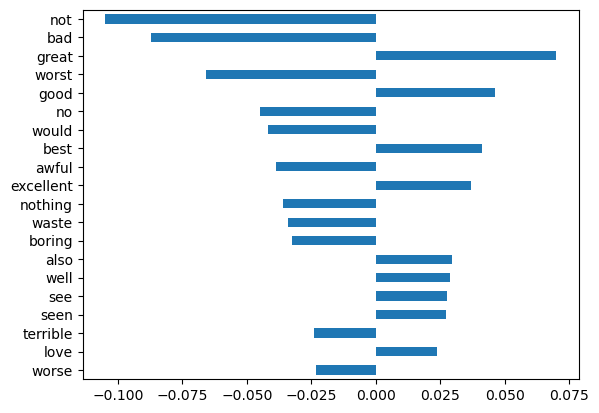

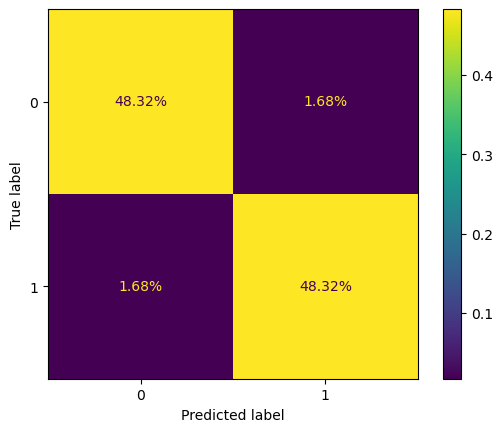

In [41]:
disp, report, feature_effects = postprocessing.results_analysis(model, df_train["review"],
                                                       df_train["sentiment"])
display(report)

## Testing

,0,1,accuracy,macro avg,weighted avg
precision,0.881878,0.889967,0.88588,0.885922,0.885922
recall,0.891120,0.880640,0.88588,0.885880,0.885880
f1-score,0.886475,0.885279,0.88588,0.885877,0.885877
support,12500.000000,12500.000000,0.88588,25000.000000,25000.000000


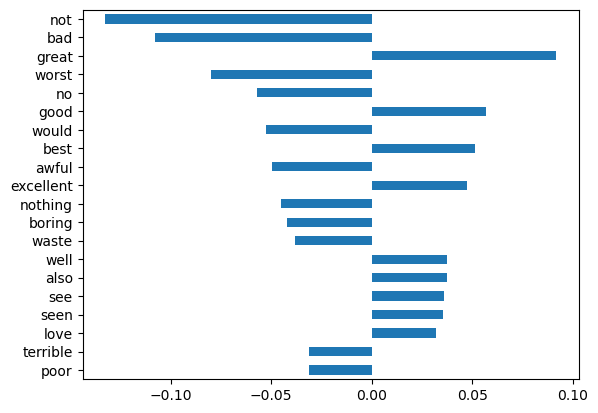

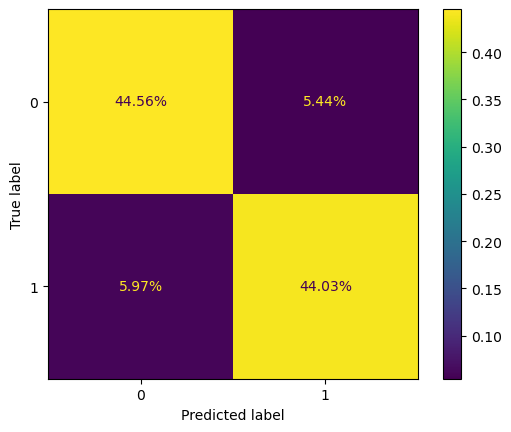

In [42]:
df_test = data.load_clean_data("./input/testData.tsv", "./input/testDataClean.tsv")


disp, report, feature_effects = postprocessing.results_analysis(model, df_test["review"],
                                                       df_test["sentiment"])
display(report)

## 

# To do next:
* Test the effects of stemming and lemmatization
* Look at the stop words and maybe remove some of them or add other words.
* Use MLFlow to manage the sklearn model saving and loading
* Use a deep learning end-to-end approach using:
  * an MLP via the sklearn implementation.
  * a recurrent neural network architecture (BRNN, GRU, LSTM, ...).
  * a transformer.